# Introduction

The [Laplace transform of a continuous random variable](https://en.wikipedia.org/wiki/Laplace_transform#Probability_theory) $X$ with probability density function (PDF) $f_X$ is defined as

$$
\mathcal{L}_X(u) = \operatorname{E} \left[ e^{-uX} \right] = \int_{-\infty}^{\infty} f_X(x)\, e^{-ux}\, dx,
$$

where $\operatorname{E}$ denotes the expectation.

In this work, we study the Laplace transform of a [lognormally distributed random variable](https://en.wikipedia.org/wiki/Log-normal_distribution). For a lognormal random variable $X \sim \mathrm{LogN}(\mu, v)$, we have $Y = \log X \sim \mathcal{N}(\mu, v)$, where $\mu$ and $v$ are the mean and variance of $\log X$, respectively. We adopt the parametrization used in the [Alternative Parameterizations](https://en.wikipedia.org/wiki/Log-normal_distribution#Alternative_parameterizations) section of the Wikipedia article.


Under this parametrization, the probability density function of $X$ is given by:

$$
f_X(x;\mu,v) = \frac{1}{x \sqrt{2\pi v}} \exp\left( -\frac{(\ln x - \mu)^2}{2v} \right), \quad x > 0.
$$

Hence, the Laplace transform becomes:

$$
\mathcal{L}(u;\mu,v) = \frac{1}{\sqrt{2\pi v}} \int_0^{\infty} \frac{1}{x} \exp\left( -ux - \frac{(\ln x - \mu)^2}{2v} \right) dx.
$$

This integral has no known closed-form expression. However, we can evaluate it numerically. To facilitate this, we apply the change of variables $Y = \ln X$, i.e., $x = e^y$, leading to:

$$
\mathcal{L}(u;\mu,v) = \operatorname{E}\left[ e^{-u e^Y} \right] = \frac{1}{\sqrt{2\pi v}} \int_{-\infty}^{\infty} \exp\left( -u e^y - \frac{(y - \mu)^2}{2v} \right) dy.
$$



Let us now shift the integration variable by an arbitrary constant $c \in \mathbb{R}$, setting

$$
z = y - c, \quad \text{so that} \quad y = z + c. \tag{1}
$$

Substituting into the integral yields:

$$
\begin{aligned}
\mathcal{L}(u;\mu,v) &= \frac{1}{\sqrt{2\pi v}} \int_{-\infty}^{\infty} \exp\left( -u e^{z + c} - \frac{(z - (\mu - c))^2}{2v} \right) dz \\
&= \frac{1}{\sqrt{2\pi v}} \int_{-\infty}^{\infty} \exp\left( -e^z (u e^c) - \frac{(z - (\mu - c))^2}{2v} \right) dz \\
&= \mathcal{L}(u e^c; \mu - c, v).
\end{aligned}
$$

This is a key identity:

$$
\mathcal{L}(u;\mu,v) = \mathcal{L}(u e^c; \mu - c, v), \quad \forall c \in \mathbb{R}. \tag{2}
$$

It immediately follows from (2) that we can always reduce the general case to the special case $\mu = 0$ by choosing $c = \mu$. Thus, in practical calculations, we focus on $\mathcal{L}(u;0,v)$, since any other case reduces to it via appropriate scaling of $u$:
$$
\mathcal{L}(u;\mu,v) = \mathcal{L}(u e^\mu; 0, v).
$$


## Continuation for complex values
Let us now extend identity (2) to complex shifts $c \in \mathbb{C}$. Let $c = a + ib$, where $|b|<\frac{\pi}{2}$ and apply substitution (1) in the integral:

$$
\mathcal{L}(u;\mu,v) = \frac{1}{\sqrt{2\pi v}} \int_{ib - \infty}^{ib + \infty} \exp\left( -e^z (u e^c) - \frac{(z + c - \mu)^2}{2v} \right) dz.
$$

The integrand

$$
f(z) = \exp\left( -e^z (u e^c) - \frac{(z + c - \mu)^2}{2v} \right)
$$

is an entire function (analytic over the whole complex plane). Therefore, for any $T > 0$, the contour integral over the rectangle with vertices at $\pm T$, $\pm T + ib$ is zero:

$$
\int_{ib - T}^{ib + T} f(z)\,dz + \int_{ib + T}^{T} f(z)\,dz + \int_T^{-T} f(z)\,dz + \int_{-T}^{ib - T} f(z)\,dz = 0.
$$


As $T \to \infty$, the contributions from the vertical segments vanish, since $\lvert f(z)\rvert$ decays rapidly whenever $\lvert b\rvert < \tfrac{\pi}{2}$.  Therefore,

$$
\int_{i b - \infty}^{i b + \infty} f(z)\,dz
\;=\;
\int_{-\infty}^{\infty} f(z)\,dz,
$$

and we conclude

$$
\mathcal{L}(u;\mu,v)
\;=\;
\mathcal{L}\bigl(u\,e^c;\,\mu - c,\,v\bigr).
\tag{3}
$$

In particular, this result extends $\mathcal{L}(u;0,v)$ to the **right half-plane** $\Re(u)>0$.  Writing
$$
u = \lvert u\rvert\,e^{\,i\arg(u)},
$$
we obtain

$$
\mathcal{L}(u;0,v)
\;=\;
\mathcal{L}\bigl(\lvert u\rvert\,e^{\,i\arg(u)};0,v\bigr)
\;=\;
\mathcal{L}\bigl(\lvert u\rvert; i\,\arg(u), v\bigr).
\tag{4}
$$

This continuation is crucial for our subsequent analysis.

Miles (2018)\[1\] shows that (4) admits a further continuation to all of $\mathbb{C}\setminus(-\infty,0]$, with two boundary values on the negative real axis (approached from above, $+0i$, and from below, $-0i$).  We will adopt the convention of taking the $+0i$ branch on the negative real axis.

---

\[1\] [J. Miles, *The Laplace transform of the lognormal distribution*, arXiv:1803.05878 (2018).](https://arxiv.org/pdf/1803.05878)


## Optimizing the Laplace Transform for Numerical Integration

We now perform another change of variables to simplify the integral. Substituting $t = z / \sqrt{2v}$ eliminates the $2v$ factor in the exponent:

$$
\mathcal{L}(u;0,v) = \frac{1}{\sqrt{2\pi v}} \int_{-\infty}^{\infty} \exp\left( -e^z u  - \frac{z^2}{2v} \right) dz = 
\frac{1}{\sqrt{\pi}} \int_{-\infty}^{\infty} \exp\left( -e^{\sqrt{2v}t} u  - t^2 \right) dt.
$$

We can rewrite this as

$$
\mathcal{L}(u;0,v) = \frac{1}{\sqrt{\pi}} \int_{-\infty}^{\infty} g(t) e^{-t^2} dt,
$$

where $g(t) = \exp(-u e^{\sqrt{2v} t})$. This integral can be evaluated numerically using **Gauss–Hermite quadrature**. The method is most accurate when the integrand $g(t)$ attains its maximum at $t = 0$. Can we ensure that this condition holds?


To answer this, consider shifting the integration variable by a real constant $c \in \mathbb{R}$:

$$
x = t - c, \quad \text{so that} \quad t = x + c.
$$

The integral becomes

$$
\mathcal{L}(u;0,v)= \frac{e^{-c^2}}{\sqrt{\pi}} \int_{-\infty}^{\infty} \exp\left( -u e^{\sqrt{2v}(x+c)} - x^2 - 2c x \right) dx = 
\frac{e^{-c^2}}{\sqrt{\pi}} \int_{-\infty}^{\infty} \exp(-f(x,c)) e^{-x^2} dx,
$$

where

$$
f(x,c) = u e^{\sqrt{2v}x} e^{\sqrt{2v}c} + 2c x.
$$


To place the maximum of the integrand at $x = 0$, we find the minimum of $f(x,c)$ by setting its derivative to zero:

$$
\frac{\partial f}{\partial x} = \sqrt{2v} u e^{\sqrt{2v}x} e^{\sqrt{2v}c} + 2c = 0.
$$

Let $a = \sqrt{2v}$. Then the equation becomes:

$$
a u e^{a x} e^{a c} = - 2c.
$$

Solving for $x$ gives:

$$
x = \frac{1}{a} \ln\left( - \frac{2c}{a u e^{a c}} \right).
$$

We want this $x$ to be zero, which yields:

$$
\frac{2c}{a u e^{a c}} = - 1 \tag{5}
$$

Rewriting:

$$
-a c e^{-a c} = \frac{a^2 u}{2}
$$

Now apply the **Lambert W function** to both sides. Since $a^2/2 = v$, we obtain:

$$
c = -\frac{W(u v)}{\sqrt{2v}}.
$$

We denote this optimal shift by $c_{\text{opt}}$:

$$
c_{\text{opt}} = -\frac{W(uv)}{\sqrt{2v}}.
$$


From equation (5), we also get:

$$
u e^{a c_{\text{opt}}} = - \frac{2 c_{\text{opt}}}{\sqrt{2v}}.
$$

Substituting back into $f(x, c_{\text{opt}})$:

$$
f(x, c_{\text{opt}}) = -\frac{2 c_{\text{opt}}}{\sqrt{2v}} e^{\sqrt{2v}x} + 2 c_{\text{opt}} x.
$$

For practical computations, it is more convenient to define

$$
s = W(u v)
$$

so that

$$
c_{\text{opt}} = -\frac{s}{\sqrt{2v}}.
$$

Then the function simplifies to:

$$
f(x, s) = \frac{s}{v} (e^{\sqrt{2v}x} - \sqrt{2v} x),
$$

and the Laplace transform becomes:

$$
\mathcal{L}(u;0,v) = \frac{\exp\left(-\frac{s^2}{2v}\right)}{\sqrt{\pi}} \int_{-\infty}^{\infty} \exp\left( -f(x, s) \right) e^{-x^2} dx.
$$

We can now effectively apply **Gauss–Hermite quadrature** for real $u$.

---

## Extension to Complex Values

For complex values of $u$, consider evaluating $\mathcal{L}(u e^{i\phi}; 0, v)$ for real $u$ and phase $\phi$. From the earlier identity (4):

$$
\mathcal{L}(u e^{i\phi};0,v) = \mathcal{L}\bigl(u; i\phi, v\bigr)=\frac{1}{\sqrt{2\pi v}} \int_{-\infty}^{\infty} \exp\left( -u e^z - \frac{(z - i\phi)^2}{2v} \right) dz
=\frac{1}{\sqrt{2\pi v}} \int_{-\infty}^{\infty} \exp\left( -u e^z - \left(\frac{z}{\sqrt{2v}} - \frac{i\phi}{\sqrt{2v}}\right)^2 \right) dz.
$$

Changing variables again with $t = z / \sqrt{2v}$:

$$
= \frac{1}{\sqrt{\pi}} \int_{-\infty}^{\infty} \exp\left( -u e^{\sqrt{2v}t} - (t - \frac{i\phi}{\sqrt{2v}})^2 \right) dt 
= \frac{e^{\phi^2}}{\sqrt{\pi}} \int_{-\infty}^{\infty} \exp\left( -u e^{\sqrt{2v}t} + \frac{2i\phi}{\sqrt{2v}} t \right)e^{- t^2} dt.
$$

Now consider the absolute value of the complex exponential term:

$$
\left| \exp\left( -u e^{\sqrt{2v}t} + \frac{2i\phi}{\sqrt{2v}}t \right) \right| = \exp\left( -u e^{\sqrt{2v}t} \right),
$$

which is independent of $\phi$. Therefore, the same optimal shift $c_{\text{opt}} = -s/\sqrt{2v}$ works as before.

We now define the complex function:

$$
f(x, s, \phi) = \frac{s}{v} e^{\sqrt{2v}x} - \frac{(s + i\phi)}{v} \sqrt{2v} x,
$$
where we make substitution as before

$$
x = t - c_{\text{opt}}, \quad \text{so that} \quad t = x + c_{\text{opt}}
$$


and the Laplace transform becomes:

$$
\mathcal{L}(u e^{i\phi};0,v) = \frac{\exp\left( -\frac{(s + i\phi)^2}{2v} \right)}{\sqrt{\pi}} \int_{-\infty}^{\infty} \exp\left( -f(x, s, \phi) \right) e^{-x^2} dx.
$$



To use  Gauss–Hermite quadrature we need nodes and weights $x_i,\,\,w_i$ of appropriate order $n$. Then the integral estimated as
$$
\int_{-\infty}^{\infty} \exp\left( -f(x, s, \phi) \right) e^{-x^2} dx \approx \sum_i\exp\left( -f(x_i, s, \phi) \right)w_i
$$
If we scale $x_i,\,\,w_i$ on factors $\sqrt{2v}$ and $1/\sqrt{\pi}$ we can simplify the computations
$$
x_i^\text{sc}=\sqrt{2v}x_i, \,\, w_i^\text{sc}=\frac{w_i}{\sqrt{\pi}}
$$

$$
\mathcal{L}(u e^{i\phi};0,v) \approx \exp( -\frac{v\,a^2}{2})\sum_i\exp\left(a\,x_i^\text{sc}-\Re(a)\,e^{x_i^\text{sc}}\right)w_i^\text{sc}
$$
where
$$
a=\frac{s+i\phi}{v}=\frac{W(u\,v)+i\phi}{v}.
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as scsp
import sys
plt.style.use('seaborn-v0_8-darkgrid')


## Numerical Evaluation of the Laplace Transform

We begin by defining two helper functions used to compute the Laplace transform numerically using Gauss–Hermite quadrature.


In [2]:
def hermite_gauss_scaled(n, toll=1.e-18):
    '''
    Returns a filtered list of Hermite–Gauss quadrature nodes and weights of order n.
    Only terms where weight / max_weight > toll are retained.
    nodes scaled by sqrt(2), wiegthts by 1/sqrt(pi)
    '''
    xi, wi = np.polynomial.hermite.hermgauss(n)
    # Terms with very small weights will be lost due to numerical rounding errors,
    # so we exclude them to improve numerical stability.
    toll = toll * np.max(wi)
    k = np.argmax(wi[:n//2] > toll)
    sqrt2=1.4142135623730951
    sqrt_pi_inv=0.56418958354775628 # 1/sqrt(pi)
    if k != 0:
        xi, wi = xi[k:-k], wi[k:-k]
    return xi*sqrt2, wi*sqrt_pi_inv    

In [3]:
def laplace_by_integration_base(xi, wi, u, v, i_phi=0):
    '''
    Computes the Laplace transform at the point u * exp(i * phi),
    using precomputed Hermite–Gauss nodes (xi) and weights (wi).
    
    Arguments:
    - xi, wi: Hermite–Gauss nodes and weights scaled on sqrt(2) and 1/sqrt(pi)
    - u: real-valued base magnitude of the argument
    - v: log-variance parameter of the lognormal distribution
    - i_phi: phase of the complex argument (defaults to 0 for real arguments)
    '''
    xi = xi*np.sqrt(v) # v-depentent part of the scaling 
    a = (np.real(scsp.lambertw(np.atleast_1d(u) * v)) + i_phi)/v
    # The exponential term in the integrand, vectorized over all xi
    exp_term = np.outer(a, xi) - np.outer(np.real(a), np.exp(xi)) 
    # Gauss–Hermite quadrature integration
    vals = np.dot(np.exp(exp_term), wi)
    return np.exp((-.5*v)*a**2) * vals.reshape(a.shape)      

Next, we define several factory functions that return callable Laplace transform functions for real or complex arguments. These factories precompute Hermite–Gauss nodes and weights so that repeated evaluations (e.g., in loops) are more efficient.

Functions ending with _uvF return a function that accepts both $u$ and $v$ as arguments.
Functions ending with _uF return a function where $v$ is fixed during construction, and only $u$ needs to be passed later. 

### Real-valued Laplace Transform

In [4]:
def LTLN_DI_real_uvF(n=35,toll=sys.float_info.epsilon/10.):
    xi, wi = hermite_gauss_scaled(n,toll/n)
    return lambda u,v:laplace_by_integration_base(xi,wi,u,v)
    
def LTLN_DI_real_uF(v, n=35,toll=sys.float_info.epsilon/10.):
    xi, wi = hermite_gauss_scaled(n,toll/n)
    return lambda u:laplace_by_integration_base(xi,wi,u,v)


### Complex-valued Laplace Transform

In [5]:
def LTLN_DI_complex_uvF(n=35,toll=sys.float_info.epsilon/10.):
    xi, wi = hermite_gauss_scaled(n,toll/n)
    return lambda u,v: laplace_by_integration_base(xi,wi,np.abs(u),v,1j*np.angle(u))

def LTLN_DI_complex_uF(v, n=35,toll=sys.float_info.epsilon/10.):
    xi, wi = hermite_gauss_scaled(n,toll/n)
    return lambda u: laplace_by_integration_base(xi,wi,np.abs(u),v,1j*np.angle(u))


### Negative-valued -0i Laplace Transform

In [6]:
def LTLN_DI_neg_uvF(n=35,toll=sys.float_info.epsilon/10.):
    xi, wi = hermite_gauss_scaled(n,toll/n)
    return lambda u,v: laplace_by_integration_base(xi,wi,np.abs(u),v,-1j*np.pi)

def LTLN_DI_neg_uF(v, n=35,toll=sys.float_info.epsilon/10.):
    xi, wi = hermite_gauss_scaled(n,toll/n)
    return lambda u: laplace_by_integration_base(xi,wi,np.abs(u),v,-1j*np.pi)


These function factories allow efficient and reusable evaluation of the Laplace transform of the lognormal distribution for both real and complex arguments.

## Visualization of the Laplace Transform Along Different Rays in the Complex Plane

Below we demonstrate how to use the `_uvF` factory to compute and visualize the Laplace transform of the lognormal distribution along three rays in the complex plane:

1. Along the **positive real axis**: $ u \in [0, 100] $
2. Along the **imaginary axis**: $ u = i t,\; t \in [-20, 20] $
3. Along the **negative real axis**: $ u = -t,\; t \in [10^{-2}, \cdot 10^2] $

We do this for multiple values of the log-variance parameter $v$. In the imaginary and negative real cases, the Laplace transform takes **complex values**, so we plot both real and imaginary parts.


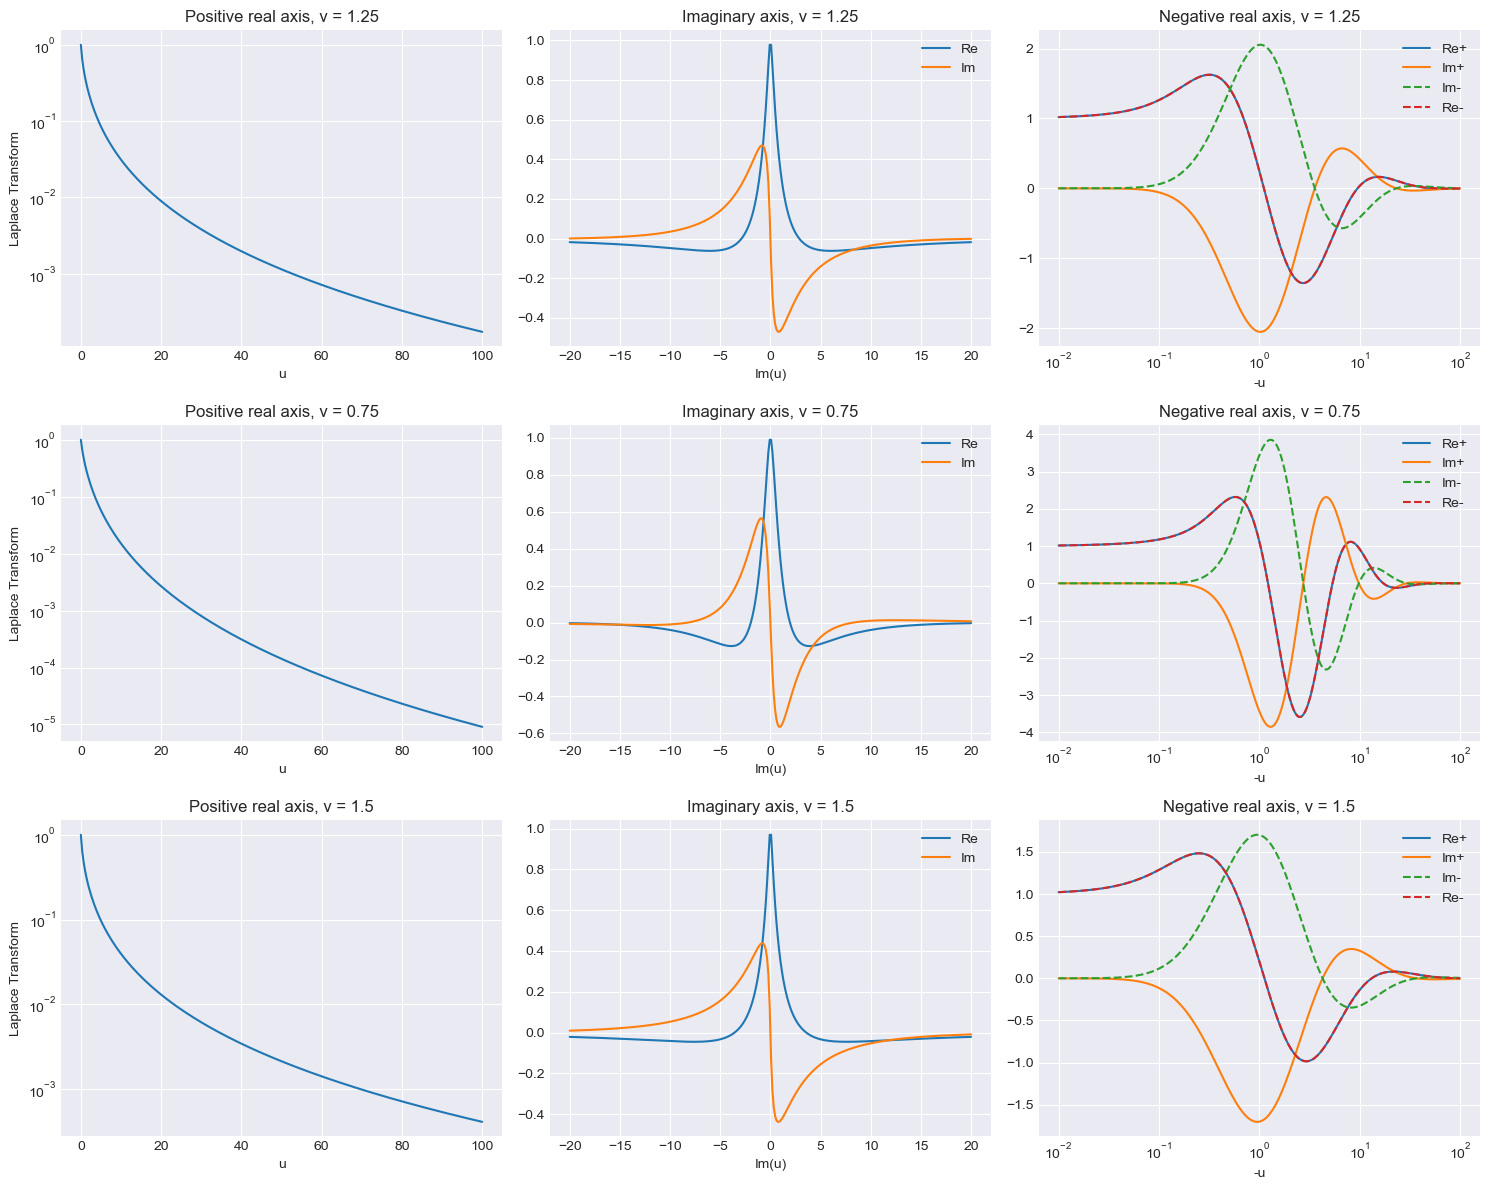

In [7]:
# Factory from earlier cell
lt_fn_pos = LTLN_DI_real_uvF()
lt_fn = LTLN_DI_complex_uvF()
lt_fn_neg = LTLN_DI_neg_uvF()

# Define v values
v_vals = [1.25, 0.75, 1.5]

# Define u values along each ray
u_real = np.linspace(0, 100, 300)
u_imag = 1j * np.linspace(-20, 20, 300)
u_neg = - np.logspace(-2, 2, 300)

fig, axs = plt.subplots(len(v_vals), 3, figsize=(15, 4 * len(v_vals)))

for i, v in enumerate(v_vals):
    # Evaluate Laplace transform
    L_real = lt_fn_pos(u_real, v)
    L_imag = lt_fn(u_imag, v)
    L_neg_plus  = lt_fn(u_neg,  v)
    L_neg_minus  = lt_fn_neg(u_neg,  v)

    # --- Positive real axis ---
    axs[i, 0].plot(u_real, L_real, label="Re")
    axs[i, 0].set_yscale("log")
    axs[i, 0].set_title(f"Positive real axis, v = {v}")
    axs[i, 0].set_xlabel("u")
    axs[i, 0].set_ylabel("Laplace Transform")

    # --- Imaginary axis ---
    axs[i, 1].plot(u_imag.imag, L_imag.real, label="Re")
    axs[i, 1].plot(u_imag.imag, L_imag.imag, label="Im")
    axs[i, 1].set_title(f"Imaginary axis, v = {v}")
    axs[i, 1].set_xlabel("Im(u)")
    axs[i, 1].legend()

    # --- Negative real axis ---
    axs[i, 2].plot(-u_neg, L_neg_plus.real, label="Re+")
    axs[i, 2].plot(-u_neg, L_neg_plus.imag, label="Im+")
    axs[i, 2].plot(-u_neg, L_neg_minus.imag, label="Im-", linestyle="--")
    axs[i, 2].plot(-u_neg, L_neg_minus.real, label="Re-" , linestyle="--")
    axs[i, 2].set_xscale("log")
    axs[i, 2].set_title(f"Negative real axis, v = {v}")
    axs[i, 2].set_xlabel("-u")
    axs[i, 2].legend()

plt.tight_layout()
plt.show()


The plots illustrate how the Laplace transform behaves under complex arguments:

- Along the positive real axis, the transform remains real and positive.
- Along the imaginary axis, it becomes complex-valued, oscillating with increasing imaginary part.
- Along the negative real axis, branching in the imaginary part arises from the choice of continuation across the branch cut $(-\infty, 0)$ the real part remains continuous and coincides on both sides.

Below the same picture in 3D. 

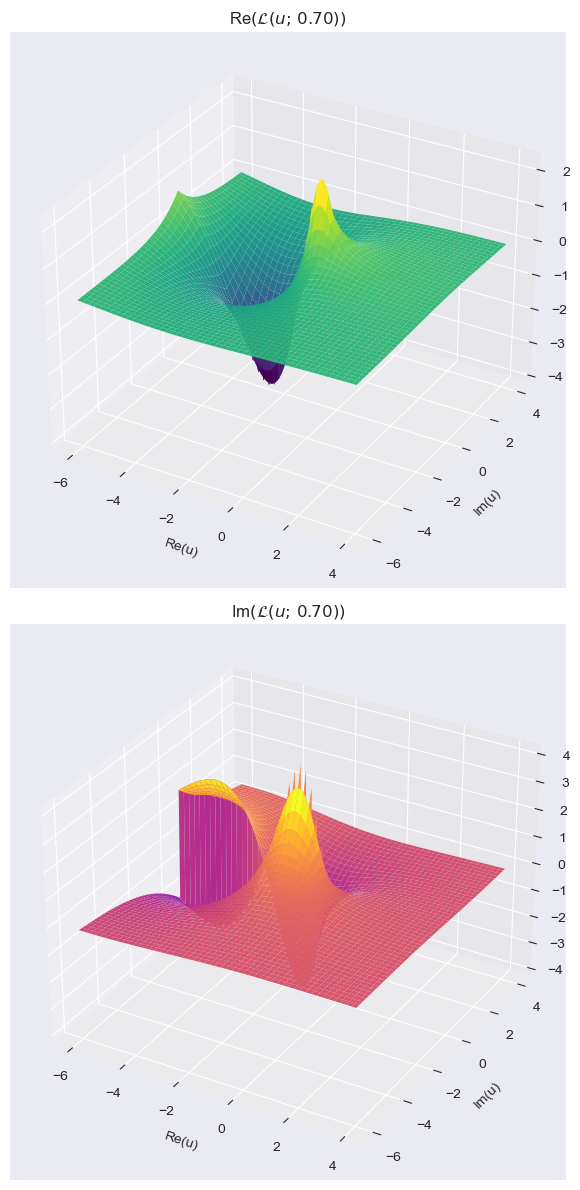

In [8]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# Параметры
v = 0.7
x_vals = np.linspace(-6, 4, 200)
y_vals = np.linspace(-6, 4, 200)

# Создаем сетку комплексных чисел u = x + i y
X, Y = np.meshgrid(x_vals, y_vals)
U = X + 1j * Y

# Получаем функцию преобразования Лапласа при фиксированном v
laplace_fn = LTLN_DI_complex_uF(v)

# Вычисляем значения на сетке
L_vals = laplace_fn(U)
L_re = np.real(L_vals)
L_im = np.imag(L_vals)

# Строим 3D-графики
fig = plt.figure(figsize=(8, 12))

# Действительная часть
ax1 = fig.add_subplot(2, 1, 1, projection='3d')
ax1.plot_surface(X, Y, L_re, cmap='viridis', edgecolor='none')
ax1.set_title(r'Re$(\mathcal{L}(u;\, %.2f))$' % v)
ax1.set_xlabel('Re(u)')
ax1.set_ylabel('Im(u)')
ax1.set_zlabel('Re(L)',labelpad=5)

# Мнимая часть
ax2 = fig.add_subplot(2, 1, 2, projection='3d')
ax2.plot_surface(X, Y, L_im, cmap='plasma', edgecolor='none')
ax2.set_title(r'Im$(\mathcal{L}(u;\, %.2f))$' % v)
ax2.set_xlabel('Re(u)')
ax2.set_ylabel('Im(u)')
ax2.set_zlabel('Im(L)',labelpad=5)

plt.tight_layout()
plt.show()


## Approximation of the Laplace transform
Our goal is to explore methods approximating the Laplace transform of the lognormal distribution. In the literature there are several attempts based on series expansion, but all of them computationally expensive.

In
[S. Asmussen, J.L. Jensen, L. Rojas-Nandayapa (2016). "On the Laplace transform of the Lognormal distribution", Methodology and Computing in Applied Probability 18 (2), 441-458](https://link.springer.com/article/10.1007/s11009-014-9430-7)
there is fast approximation 

$$\mathcal{L}^*_v(u)=\frac{\exp\left(-\frac{W(\theta)(W(\theta)+ 2)}{2v} \right)}{\sqrt{1+W(\theta)}}$$
where
$$\theta=uv$$

and $W$ is the Lambert W function.

In [9]:
def LaplTrLNApprox(u,v):
    theta=u*v
    W=np.real(scsp.lambertw(theta))
    return np.exp(-W*(W+2)/(2*v))/np.sqrt(1+W)

Shall we take a look?

In [10]:
modeling_period=10.0
u_step=0.002
u_r=np.arange(0.0, modeling_period+u_step, u_step,dtype=np.float64)
v0=[0.75,1.25]

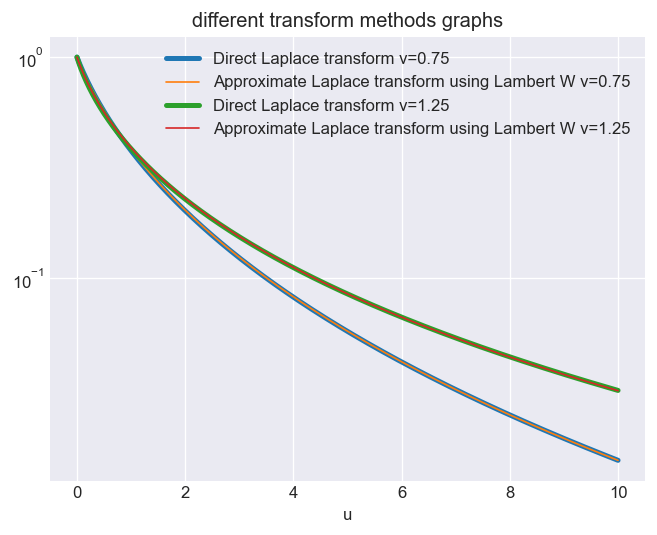

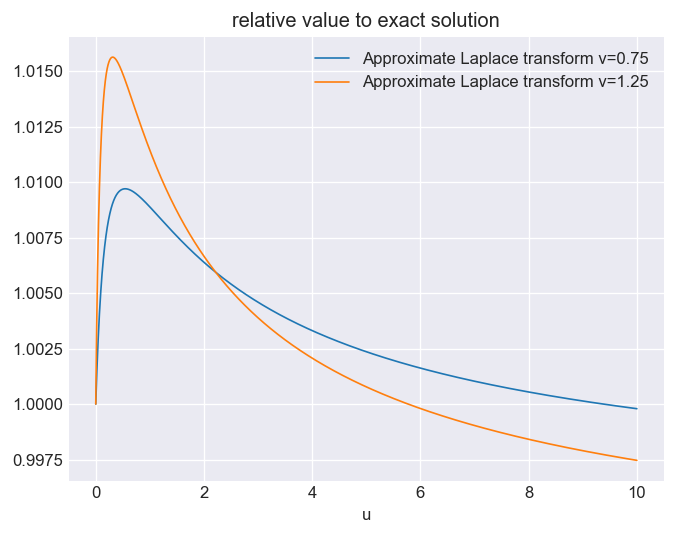

In [11]:
fig, ax = plt.subplots(dpi=120)
plt.title(f'different transform methods graphs')

for v in v0:
    plt.plot(u_r,lt_fn_pos(u_r,v), linewidth=3, label=f'Direct Laplace transform v={v}')
    plt.plot(u_r,LaplTrLNApprox(u_r,v),linewidth=1, label=f'Approximate Laplace transform using Lambert W v={v}')

plt.xlabel('u')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(dpi=120)
plt.title(f'relative value to exact solution')
for v in v0:
    plt.plot(u_r,LaplTrLNApprox(u_r,v)/lt_fn_pos(u_r,v),linewidth=1, label=f'Approximate Laplace transform v={v}')

plt.xlabel('u')
plt.legend(loc='upper right')
plt.show()

Next chapter [2.1.Idea,ODE, first results.ipynb](2.ODE/2.1.Idea%2CODE%2C%20first%20results.ipynb)